[Lecture](https://youtu.be/wAEZquYe31M)


[View in Colaboratory](https://colab.research.google.com/github/schwaaweb/aimlds1_08-UnsupervisedLearning/blob/master/T08_CCS--TC--Solution_of_Applied_Clustering_CC.ipynb)

## Applied Clustering Coding Challenge

# Clustering text documents using k-means

Clustering is commonly used to create classifications for written text using Natural Language Processing ([NLP](https://learn.lambdaschool.com/ml/sprint/recelerz9zemekmia)) techniques. This approach is highlighted by a combination of supervised and unsupervised techniques - given a huge (and growing) corpus of literature, it may be very hard for observers to classify each document. A clustering approach allows classes to be generated automatically, grouping each document into like clusters. Then, researchers may fit the clustering to specific documents that they wish to get better insigned into. Any document that shares a cluster with the tagged documents of interest then becomes a document of interest.

In this CC, we will do feature extraction and clustering on a collection of newgroup documents.

Text documents are not directly classifiable by ML algorithms, the must first be "Vectorized", that is, turned into numerical vectors by some process. Then each document becomes (as you are now familiar with) a single point in a high dimensional space. Then k-Means or any other ML algorithm can be used for processing. Vectorizing the documents is also called "feature extraction": using either of the two below algorithms a text file is converted into a set of features, aka a numerical row in a database, aka a single sample of `X`, aka a point in a high dimensional space.

Two feature extraction methods can be used in this example:

  - [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) ([Term-Frequency Inverse-Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) uses a in-memory vocabulary (a python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.

  - [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-ball) which seems to be important for k-means to work in high dimensional space.

    HashingVectorizer does not provide IDF weighting as this is a stateless
    model (the fit method does nothing). When IDF weighting is needed it can
    be added by pipelining its output to a TfidfTransformer instance.
    
Try both of these feature extractors and compare them:

In [2]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
import sys
from time import time

import numpy as np


# #############################################################################
# Load all categories from the training set
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target

print('Dataset exemplar:')
print(dataset.data[18845])

# How many actual classes are there?
true_k = np.unique(labels).shape[0]

Loading 20 newsgroups dataset for categories:
None
18846 documents
20 categories

Dataset exemplar:
From: chriss@netcom.com (Chris Silvester)
Subject: "Production Hold" on '93 Firebird/Camaro w/ 6-Speed
Organization: Netcom - Online Communication Services (408 241-9760 guest)
Distribution: usa
Lines: 30

After a tip from Gary Crum (crum@fcom.cc.utah.edu) I got on the Phone
with "Pontiac Systems" or "Pontaic Customer Service" or whatever, and
inquired about a rumoured Production Hold on the Formula Firebird and
Trans Am.  BTW, Talking with the dealer I bought the car from got me
nowhere.  After being routed to a "Firebird Specialist", I was able
to confirm that this is in fact the case.

At first, there was some problem with the 3:23 performance axle ratio.
She wouldn't go into any details, so I don't know if there were some
shipped that had problems, or if production was held up because they
simply didn't have the proper parts from the supplier.  As I say, she
was pretty vague on that,

In [3]:
print(labels[0])
print(dir(dataset))
print(dataset.DESCR)
print(dataset.description)
print(dataset.filenames)
print(dataset.target)
print(dataset.target_names)

10
['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']
None
the 20 newsgroups by date dataset
['/content/scikit_learn_data/20news_home/20news-bydate-test/rec.sport.hockey/54367'
 '/content/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60215'
 '/content/scikit_learn_data/20news_home/20news-bydate-train/talk.politics.mideast/76120'
 ...
 '/content/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695'
 '/content/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319'
 '/content/scikit_learn_data/20news_home/20news-bydate-test/rec.autos/103195']
[10  3 17 ...  3  1  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.polit

## Specify the method of feature extraction and other parameters


In [ ]:
use_hashing = False
use_idf = True
n_features = 10000
n_components = 0
minibatchKMeans = False 

## Define the feature extractor class and apply it to the  dataset

In [36]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()

if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

Extracting features from the training dataset using a sparse vectorizer
done in 5.363262s
n_samples: 18846, n_features: 10000



## Potentially, also do dimensionality reduction

In [ ]:
if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

## Then do the actual clustering and output clustering metrics

Look at using [MiniBatchKmeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) insead of regular KMeans - MiniBatch means to use a smaller subset of the data over a few passes and average their results. MiniBatch has a shorter runtime than full KMeans and can actually complete on very-large datasets.

Compare the clustering performance metrics between using KMeans and MiniBatchKMeans:
* Homogeneity
* Completeness
* V-measure
* Adjusted Rand-Index
* Silhouette

After you've finished examining the differing performance between KMeans and MiniBatchKMeans, try using a `k` other than `true_k`.

Suggestion: Write a loop that computes and outputs the Clustering Metrics for $k \in \{1...30\}$. Graph one or more of the metrics with $k$ as the `x` axis. We should see them maximize around $k=20$, the true number of clusters. Do we?

Finally, after clustering, draw some exemplar data samples from each cluster and compare them in your own mind. Is the clustering process working for separating out the content of different emails?

In [16]:
# Your implementation of Clustering Execution and Performance Metrics

if minibatchKMeans:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                        init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 39.374s



In [21]:
km_minibatch = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                        init_size=1000, batch_size=1000)
t0 = time()
km_minibatch.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

done in 0.994s



In [15]:
print(km_minibatch.predict(X[0]))
predictions = km_minibatch.predict(X[:31])
print(predictions)
which = np.where(predictions==0)[0]
#for index in which:
#    print(dataset.data[index])
    
# On this run, cluster 7 is category 10: hockey
# On this run, cluster 3 is computers
# On this run, cluster 2 mideast politics
# On this run, cluster 0 is christianity

[7]
[ 7  3  2  3  3  2  2  7  7  0  0  2  0  2  2  2  1  2  2  1  2  9  9 14
  7  2 13  9  3  0  2]


In [25]:
# Lets benchmark km_minibatch and km

def benchmark_all(labels, km):
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(labels, km.labels_))
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print('Full KM Benchmark:')
benchmark_all(labels,km)
print('Minibatch KM Benchmark:')
benchmark_all(labels,km_minibatch)


Full KM Benchmark:
Homogeneity: 0.348
Completeness: 0.422
V-measure: 0.382
Adjusted Rand-Index: 0.145
Silhouette Coefficient: 0.008
Minibatch KM Benchmark:
Homogeneity: 0.319
Completeness: 0.408
V-measure: 0.358
Adjusted Rand-Index: 0.126
Silhouette Coefficient: 0.006


In [24]:
# In this run, minibatch is .321/.348 % of the quality of full KMM
print(.319/.348)

0.9166666666666667


In [33]:
sil = 0.006
#(b-a)/b = 0.006
b = 1.06
a = 1
print((b-a)/b)

0.05660377358490571


In [46]:
print(completeness)

[0.38536031134238063, 0.400998850313491, 0.43454754212752494, 0.41812443901046287, 0.4396260878463039, 0.36250303650791976, 0.4364608585520671, 0.39141618747629986, 0.37184280607030334, 0.3714485751168977, 0.4398414387216491, 0.4428789006975637, 0.3788462286576544, 0.3605914914066264, 0.38876426054113294, 0.3887477680902338, 0.3634020674026213, 0.3991768831767991, 0.3589680656958909]


In [60]:
# How do our metrics change as the number of clusters change?

ks = np.linspace(1,39,19).astype(int)
completeness = []
for k in ks:
    print(k)
    km_minibatch = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                            init_size=2000, batch_size=2000)
    km_minibatch.fit(X)
    completeness.append(metrics.adjusted_rand_score(labels, km_minibatch.labels_))

    

1
3
5
7
9
11
13
15
17
20
22
24
26
28
30
32
34
36
39


(0, 0.5)

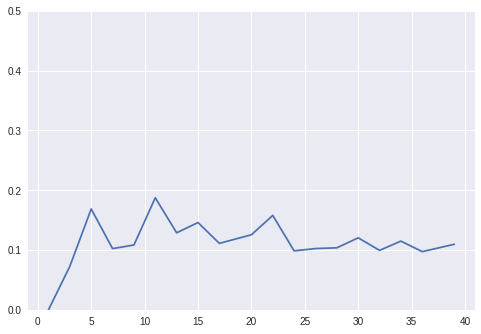

In [61]:
import matplotlib.pyplot as plt
plt.plot(ks,completeness)
plt.ylim((0,.5))